# Project

In [2]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score ,GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

## Getting data

In [3]:
# Loading Ames dataset from openml
def load_dataset():
    ames = fetch_openml(name="ames_housing")
    df = ames.frame.copy()
    return df

housing = load_dataset()
housing.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


## Exploring the dataset

In [3]:
# Looking at datastructure
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   MS_SubClass         2930 non-null   category
 1   MS_Zoning           2930 non-null   category
 2   Lot_Frontage        2930 non-null   int64   
 3   Lot_Area            2930 non-null   int64   
 4   Street              2930 non-null   category
 5   Alley               2930 non-null   category
 6   Lot_Shape           2930 non-null   category
 7   Land_Contour        2930 non-null   category
 8   Utilities           2930 non-null   category
 9   Lot_Config          2930 non-null   category
 10  Land_Slope          2930 non-null   category
 11  Neighborhood        2930 non-null   category
 12  Condition_1         2930 non-null   category
 13  Condition_2         2930 non-null   category
 14  Bldg_Type           2930 non-null   category
 15  House_Style         2930 non-null   ca

>### Observations:
> - no null values
> - 2930 entries
> - 81 features(target value included)
> - data types are (int64, float64, category)

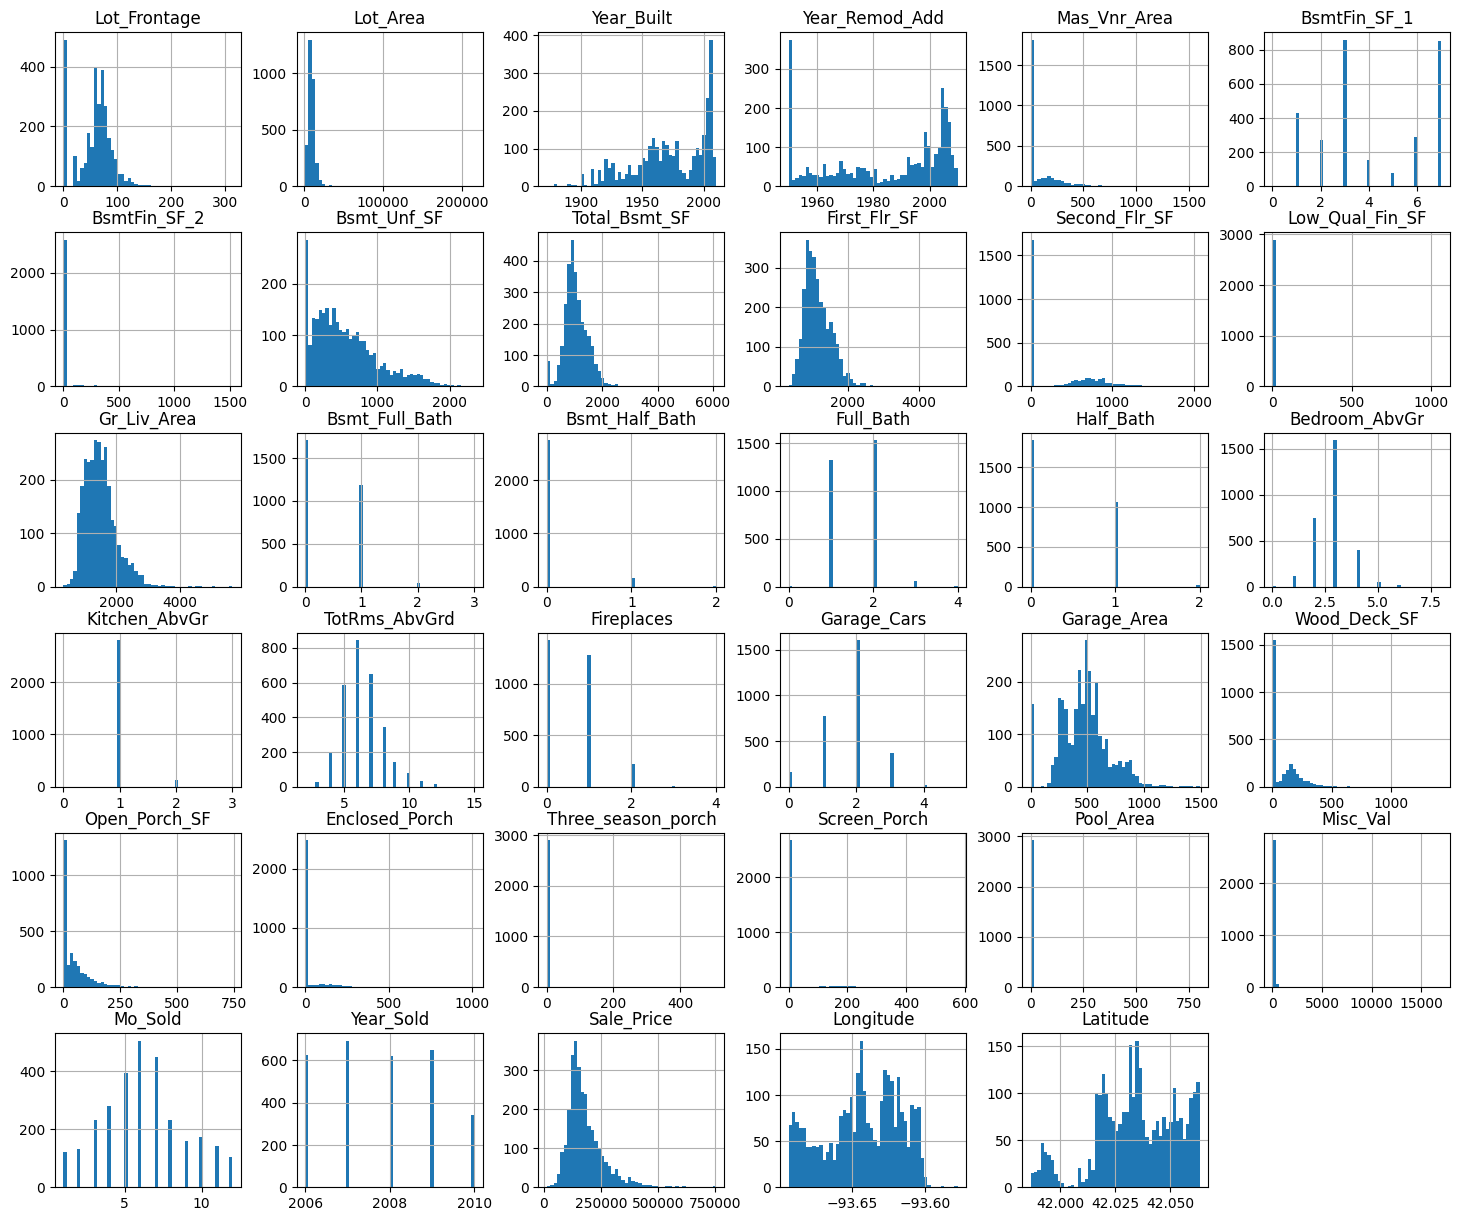

In [4]:
# Plotting historgrams of all numerical features
housing.hist(bins=50, figsize=(18,15));

>### Observation:
> - target value is right skewed distribution (taking the log might imporve model performance)
> - Lot_Frontage has missing values which are set to zero

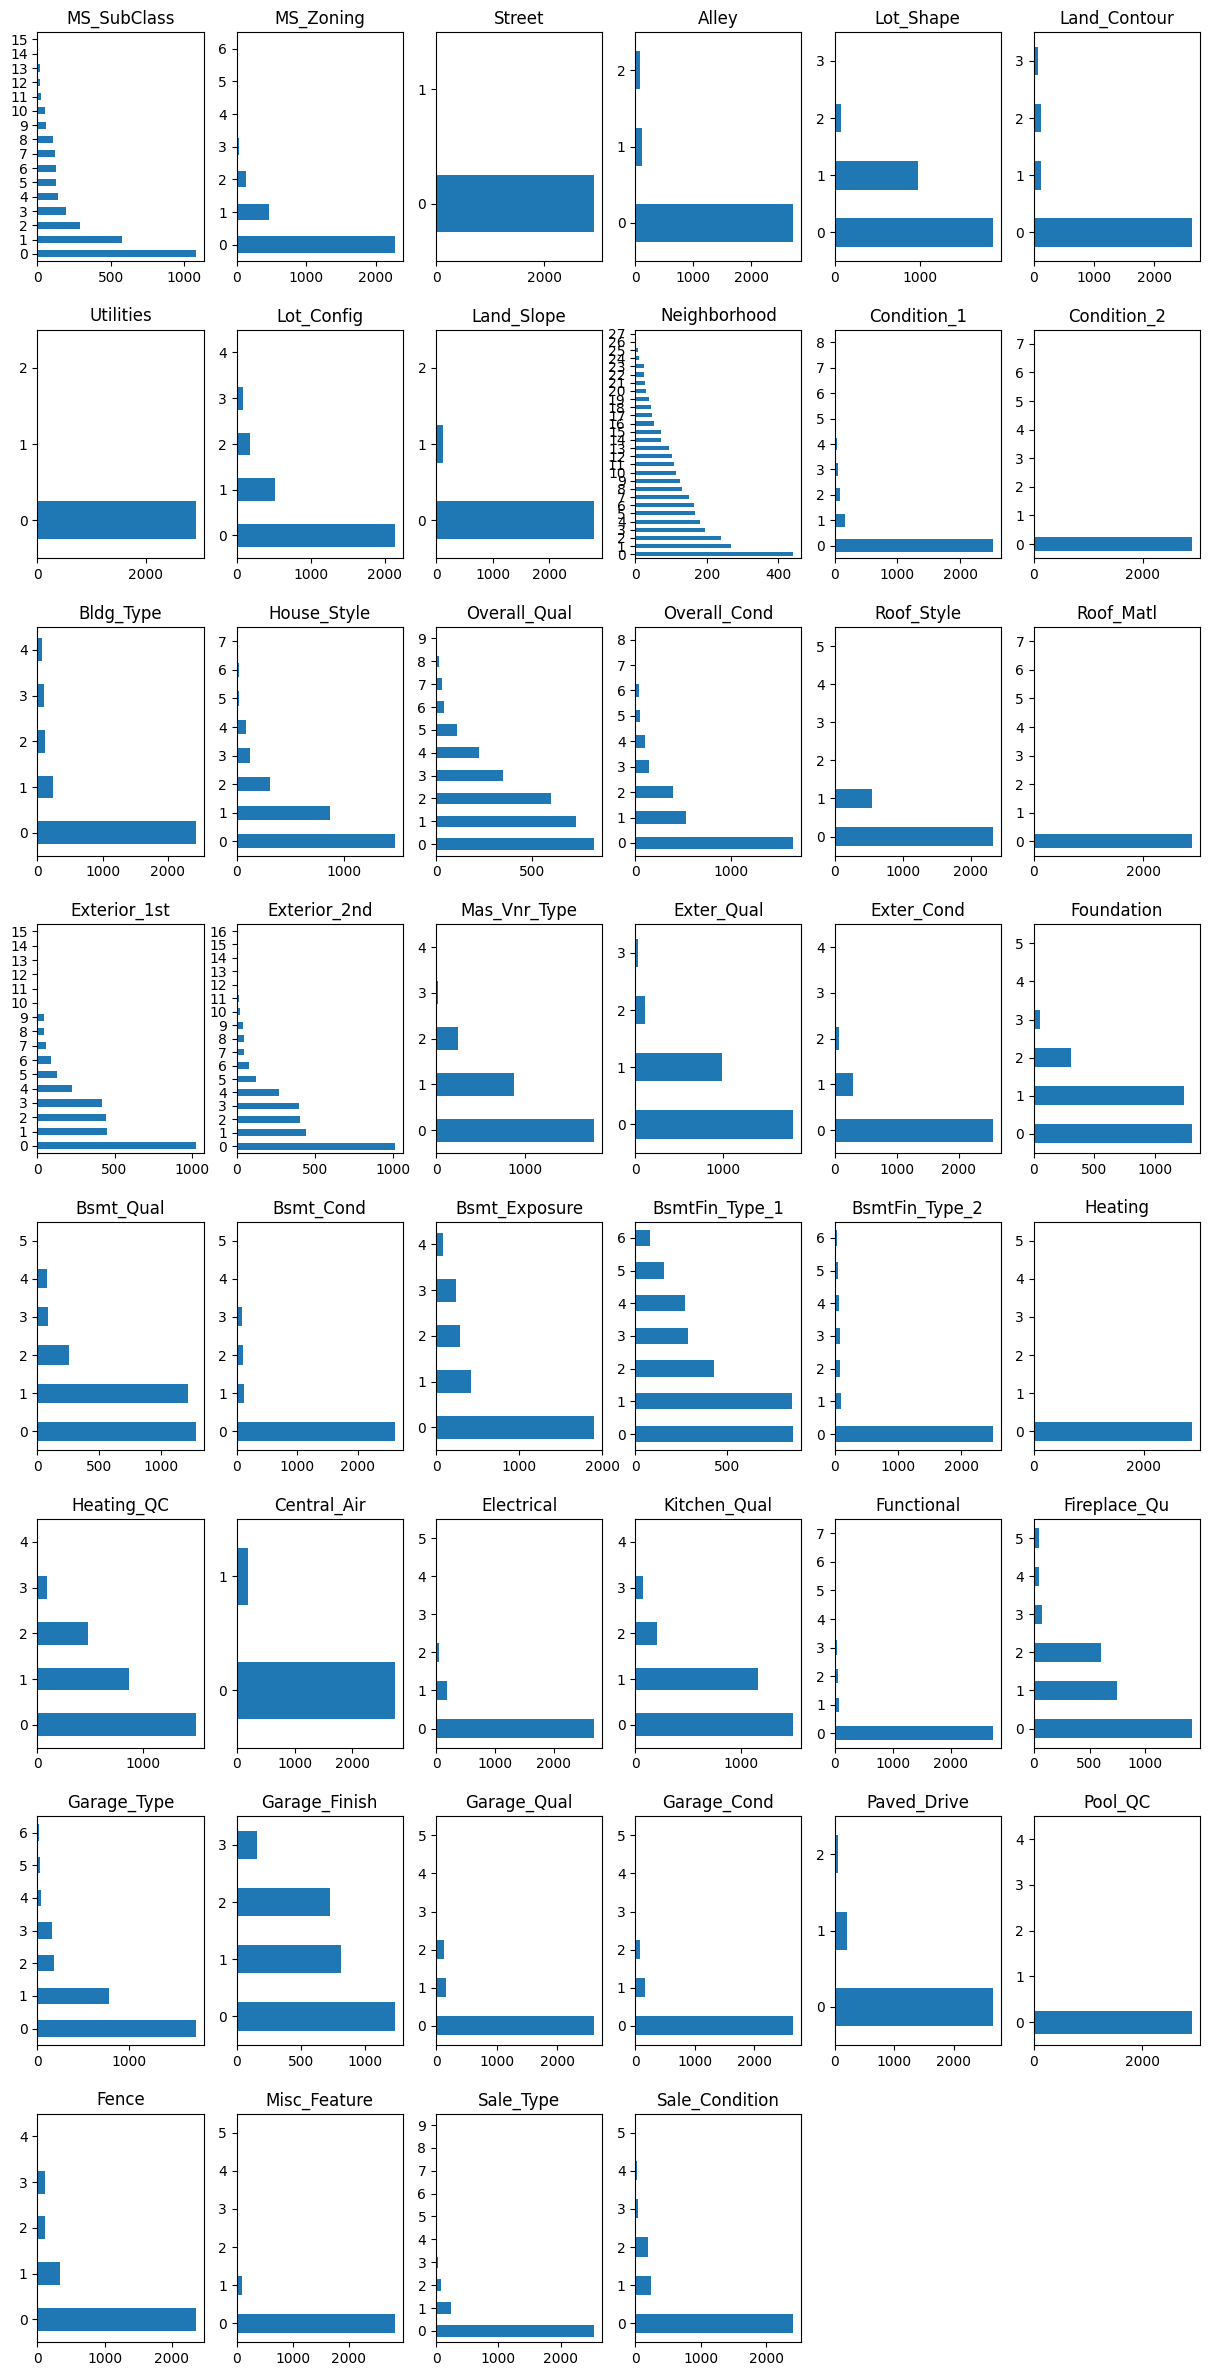

In [5]:
# Plotting historgrams of all categorical features
categorical_data = housing.select_dtypes("category")
plt.figure(figsize=(15,30))
for i, feature in enumerate(categorical_data):
    plt.subplot(8,6,i+1)
    plt.title(feature)
    pd.Series(categorical_data[feature].value_counts().values).plot.barh()
    plt.subplots_adjust(hspace=0.3)

In [6]:
# Calculating correlation and sorting in descending order
sale_price_correlation = housing.corr(numeric_only=True)["Sale_Price"].sort_values(ascending=False)
sale_price_correlation

Sale_Price            1.000000
Gr_Liv_Area           0.706780
Garage_Cars           0.647562
Garage_Area           0.640138
Total_Bsmt_SF         0.632529
First_Flr_SF          0.621676
Year_Built            0.558426
Full_Bath             0.545604
Year_Remod_Add        0.532974
Mas_Vnr_Area          0.502196
TotRms_AbvGrd         0.495474
Fireplaces            0.474558
Wood_Deck_SF          0.327143
Open_Porch_SF         0.312951
Latitude              0.290891
Half_Bath             0.285056
Bsmt_Full_Bath        0.275823
Second_Flr_SF         0.269373
Lot_Area              0.266549
Lot_Frontage          0.201875
Bsmt_Unf_SF           0.183308
Bedroom_AbvGr         0.143913
Screen_Porch          0.112151
Pool_Area             0.068403
Mo_Sold               0.035259
Three_season_porch    0.032225
BsmtFin_SF_2          0.006018
Misc_Val             -0.015691
Year_Sold            -0.030569
Bsmt_Half_Bath       -0.035817
Low_Qual_Fin_SF      -0.037660
Kitchen_AbvGr        -0.119814
Enclosed

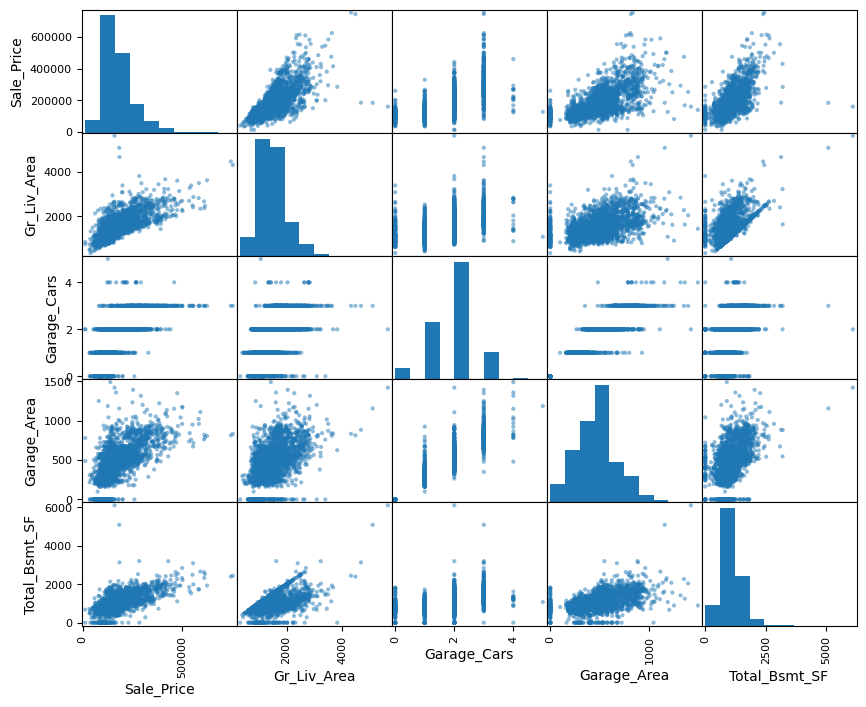

In [7]:
# Plotting scatter plots between first 5 features with higest correlation to sale price
scatter_matrix(housing[sale_price_correlation.abs().sort_values(ascending=False).index[:5]], figsize=(10,8));

>### Observation
> - Gr_Liv_Area and Total_Ssmt_SF have strong correlaction

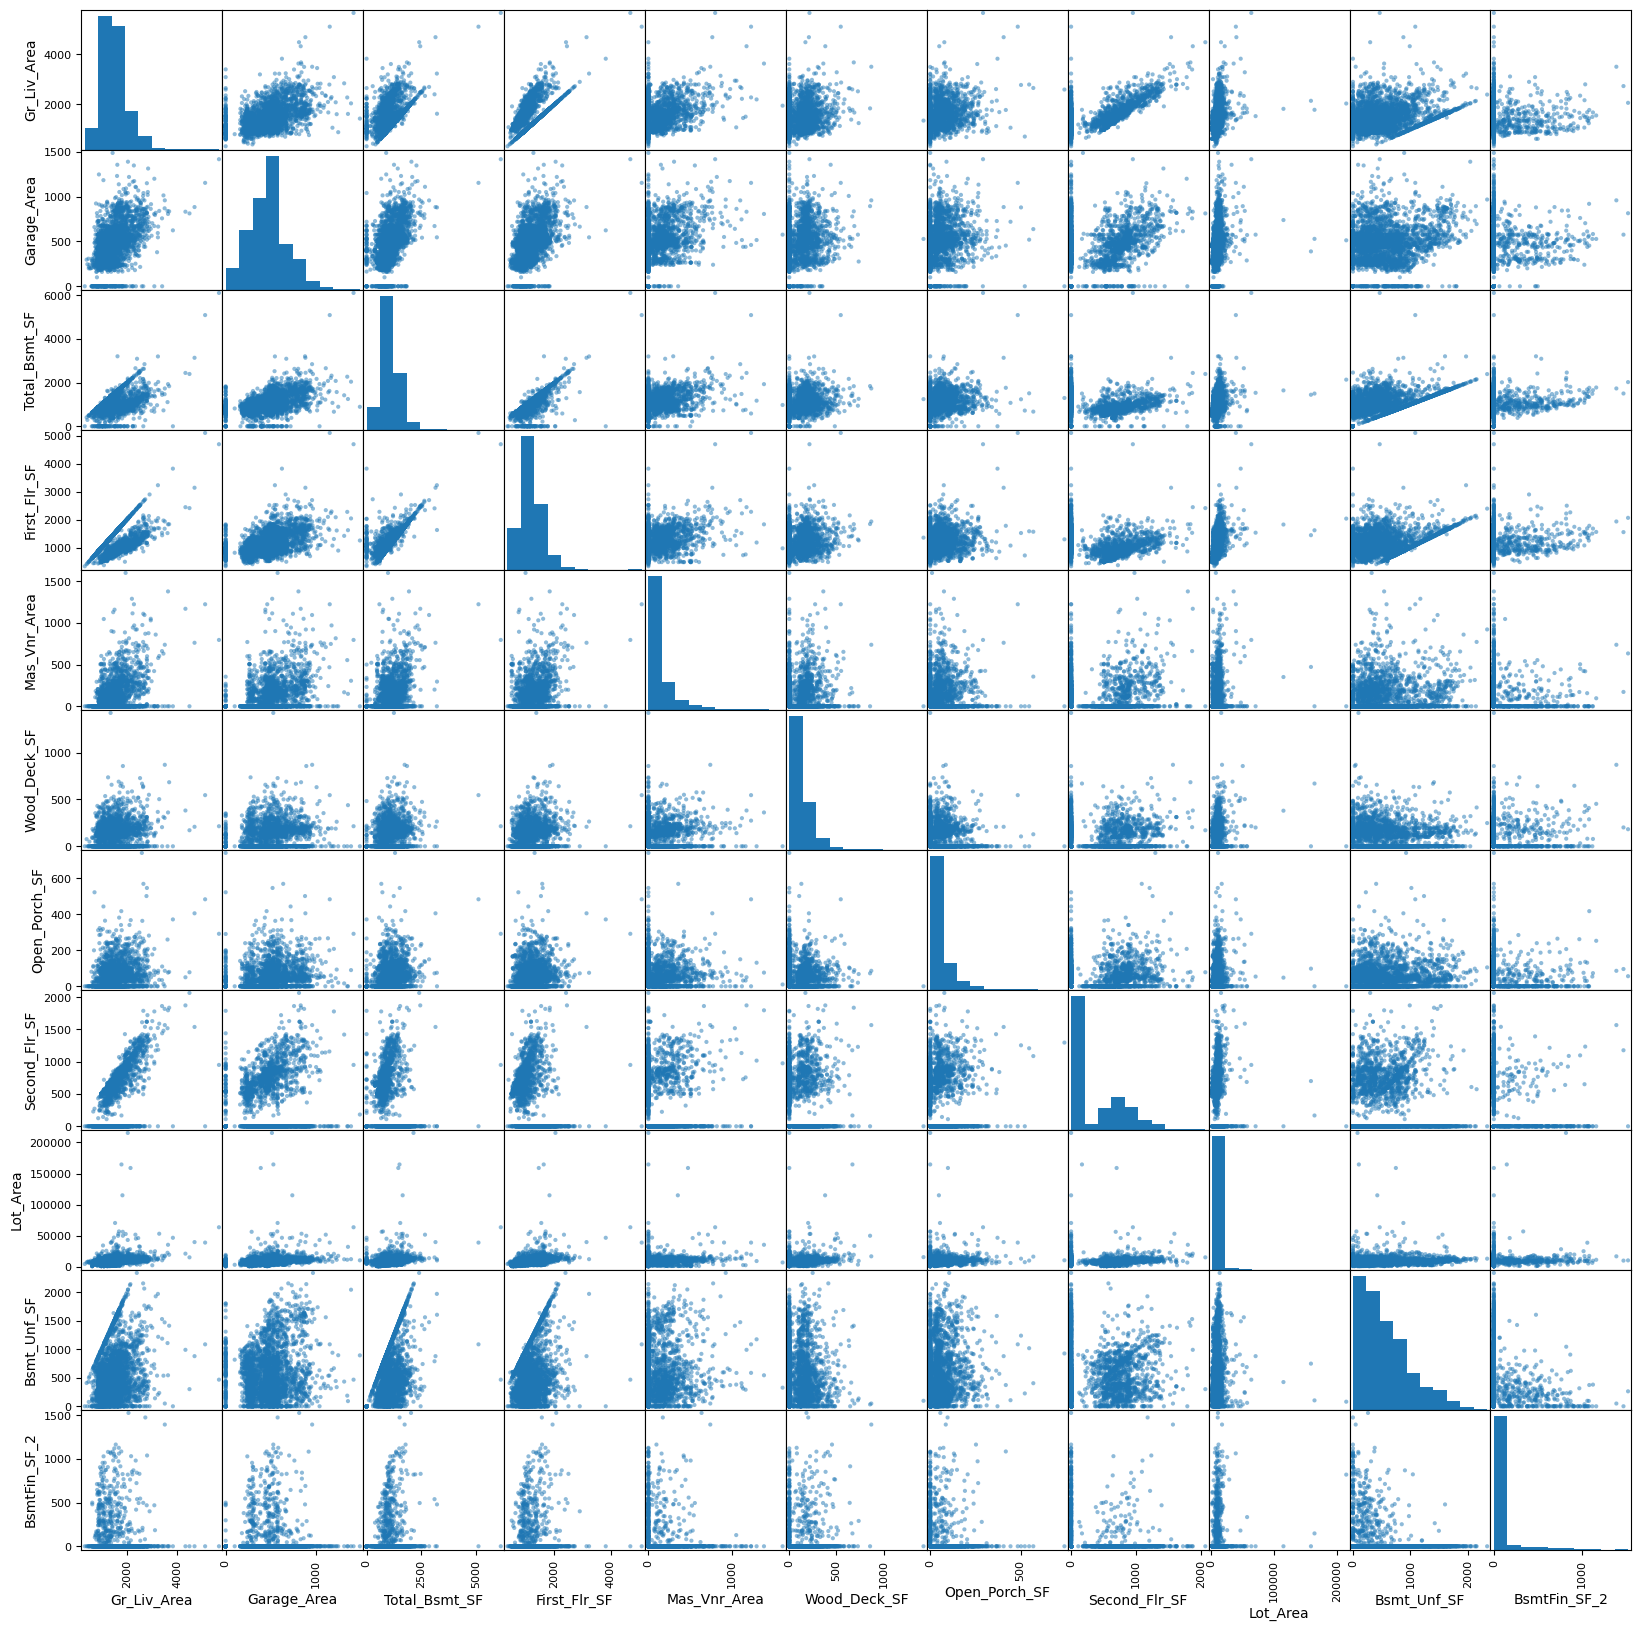

In [8]:
# Plotting scatter matrix between all the features that are in SF unit
scatter_matrix(housing[["Gr_Liv_Area","Garage_Area","Total_Bsmt_SF","First_Flr_SF",
                        "Mas_Vnr_Area","Wood_Deck_SF","Open_Porch_SF","Second_Flr_SF",
                        "Lot_Area","Bsmt_Unf_SF","BsmtFin_SF_2"]],figsize=(20,20));

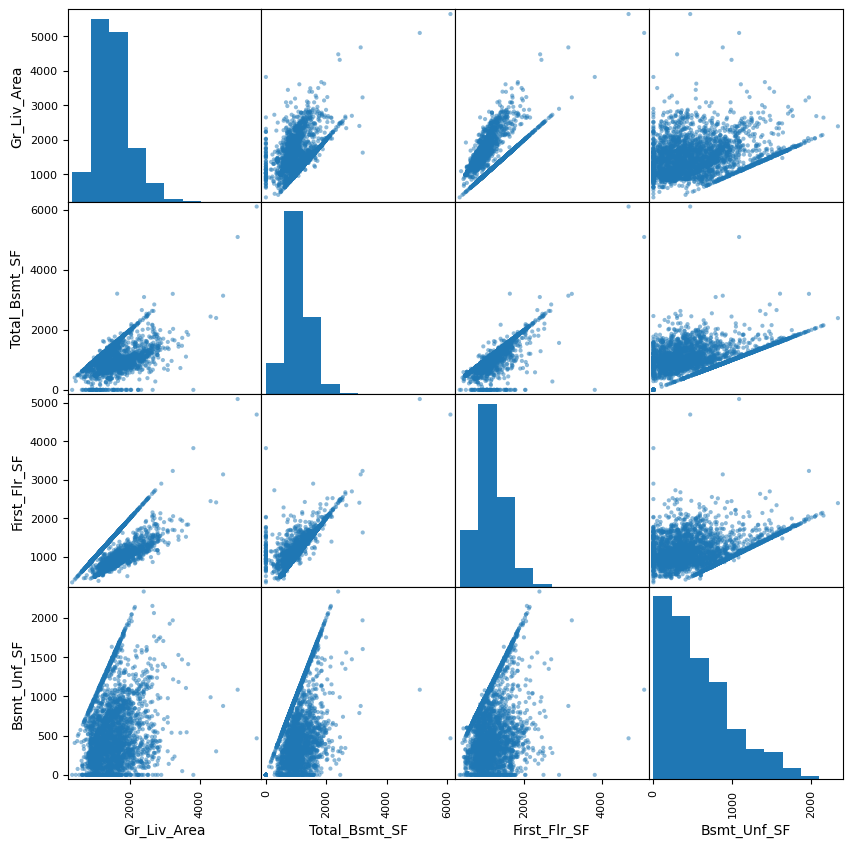

In [9]:
# Zooming in to the features with strong correlation
scatter_matrix(housing[["Gr_Liv_Area","Total_Bsmt_SF","First_Flr_SF","Bsmt_Unf_SF"]],figsize=(10,10));

## Spiltting the dataset to train and test sets

In [4]:
# Using StratifiedShuffleSplit to make equal splitting by overall qulity category
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["Overall_Qual"]):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

<Axes: xlabel='Longitude', ylabel='Latitude'>

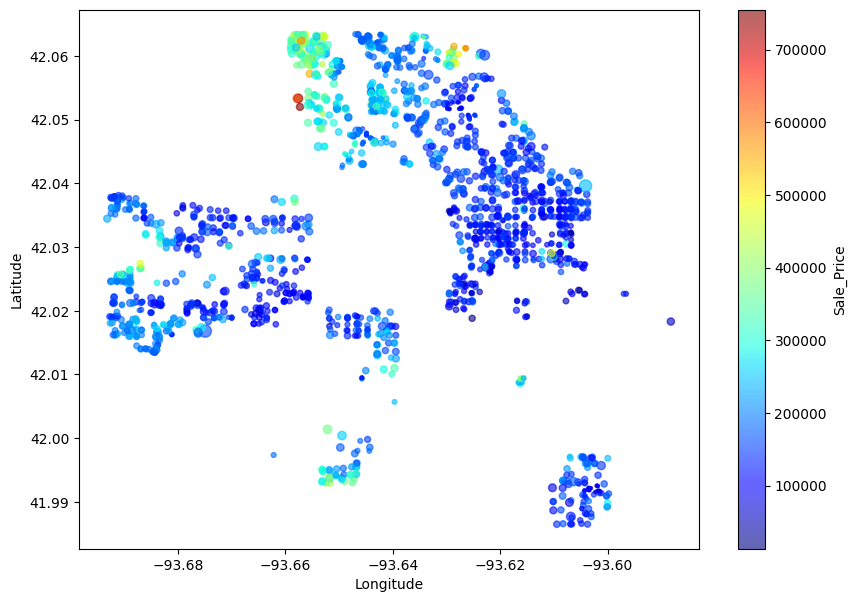

In [235]:
# Plotting houses on the map to get insight
train_set.plot(kind="scatter", x="Longitude", y="Latitude",
               alpha=0.6, s=train_set["Lot_Frontage"]/4, 
               c="Sale_Price",cmap="jet", colorbar=True, figsize=(10,7))

In [5]:
# Custom transformer to replace lot frontage values that are equal to 0 with median value of lot frontage qrouped by neighborhood
class LotFrontageTransform(BaseEstimator, TransformerMixin):
    def __init__(self, group_col="Neighborhood", target_col="Lot_Frontage"):
        self.group_col = group_col
        self.target_col = target_col
        
    def fit(self, X, y=None):
        df = X.copy()
        df[self.target_col] = df[self.target_col].replace(0, np.nan)
        self.group_medians_ = df.groupby(self.group_col, observed=True)[self.target_col].median()
        self.global_median_ = df[self.target_col].median()
        return self
        
    def transform(self, X):
        X = X.copy()
        X[self.target_col] = X[self.target_col].replace(0, np.nan)
        X[self.target_col] = X.apply(lambda row: self.group_medians_.get(row[self.group_col], self.global_median_) 
                                      if pd.isna(row[self.target_col]) else row[self.target_col],
                                      axis=1
                                     )
        X[self.target_col] = X[self.target_col].fillna(self.global_median_)
        return X

In [6]:
# Splitting train set to training features and target
train_set_X = train_set.drop(columns=["Sale_Price"])
train_set_y = train_set["Sale_Price"]

# Splitting test set to training features and target
test_set_X = test_set.drop(columns=["Sale_Price"])
test_set_y = test_set["Sale_Price"]

In [7]:
# List of features that will be encoded with ordinal encoder(mostly quality and condition features)
ordinal_columns = ['Overall_Qual', 'Overall_Cond', 'Exter_Qual', 'Exter_Cond', 
                'Bsmt_Qual', 'Bsmt_Cond', 'Heating_QC', 'Kitchen_Qual', 
                'Fireplace_Qu', 'Garage_Qual', 'Garage_Cond', 'Functional', 
                'Paved_Drive', 'Central_Air']

# Rest categorical features will be encoded as sparse onehot vector
nominal_columns = [column for column in list(housing.select_dtypes(include=["category"]).columns) if column not in ordinal_columns]

# Order of categories which will be encoded with ordinal encoder
ordinal_categories = [
    ['Very_Poor','Poor','Below_Average','Average','Fair','Above_Average',
     'Good','Very_Good','Excellent','Very_Excellent'],
    ['Very_Poor','Poor','Below_Average','Average','Fair','Above_Average',
     'Good','Very_Good','Excellent'],
    ['Typical','Fair','Good','Excellent'],
    ['Poor','Typical','Fair','Good','Excellent'],
    ['No_Basement','Poor','Typical','Fair','Good','Excellent'],
    ['No_Basement','Poor','Typical','Fair','Good','Excellent'],
    ['Poor','Typical','Fair','Good','Excellent'],
    ['Poor','Typical','Fair','Good','Excellent'],
    ['No_Fireplace','Poor','Typical','Fair','Good','Excellent'],
    ['No_Garage','Poor','Typical','Fair','Good','Excellent'],
    ['No_Garage','Poor','Typical','Fair','Good','Excellent'],
    ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    ['Dirt_Gravel', 'Partial_Pavement','Paved'],
    ['N', 'Y']
]

# Pipeline for numerical features
num_pipeline = Pipeline([
    ("lot_frontage_transform", LotFrontageTransform(group_col="Neighborhood")),
    ("drop_neighborhood", FunctionTransformer(lambda X: X.drop(columns=["Neighborhood"]), validate=False)),
])

# Full pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, list(train_set_X.select_dtypes(include=["int64","float64"]))+["Neighborhood"]),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns),
    ('onehot', OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore',dtype=np.int32), nominal_columns),
],remainder="passthrough")

## Model selection and training

In [8]:
# Initializing baseline models
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rand_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
svm_reg = SVR(kernel="linear")

In [9]:
# Transforming dataset with full_pipeline
X_train = full_pipeline.fit_transform(train_set_X)
y_train = train_set_y.copy()
X_train

array([[6.000e+01, 7.200e+03, 1.930e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [6.000e+01, 8.250e+03, 1.963e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [5.100e+01, 6.120e+03, 1.920e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [6.000e+01, 8.428e+03, 1.994e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [7.800e+01, 9.262e+03, 2.008e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [8.500e+01, 1.360e+04, 1.965e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00]], shape=(2344, 252))

Note: Using cross validation to better evaluate with 5 splits

In [10]:
# Model evaluation function with RMSE
def model_evaluation(model, cv=5):
    model_scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)
    model_rmse = np.sqrt(-model_scores)
    print("Model: ", model.__class__.__name__)
    print("Scores:", model_rmse)
    print("Mean:", model_rmse.mean())
    print("Standard deviation:", model_rmse.std())
    return model_rmse.mean()

In [11]:
%%time
# Linear Regression
lin_reg_s = model_evaluation(lin_reg)

Model:  LinearRegression
Scores: [ 44033.0201319   31597.58852915  57353.72113649 108708.44485931
  37101.32062343]
Mean: 55758.8190560596
Standard deviation: 27840.862968300073
CPU times: user 1.05 s, sys: 45.7 ms, total: 1.1 s
Wall time: 367 ms


In [12]:
%%time
# Decision tree
tree_reg_s = model_evaluation(tree_reg)

Model:  DecisionTreeRegressor
Scores: [40102.38775981 40081.982597   48447.20742648 36053.68896382
 41967.15251493]
Mean: 41330.48385240843
Standard deviation: 4048.8181265457365
CPU times: user 398 ms, sys: 0 ns, total: 398 ms
Wall time: 484 ms


In [13]:
%%time
# Random forest
rand_forest_s = model_evaluation(rand_forest_reg)

Model:  RandomForestRegressor
Scores: [25086.17143364 25042.79872761 30990.33893686 27703.98271751
 26720.95322299]
Mean: 27108.849007722056
Standard deviation: 2187.7111176299836
CPU times: user 22.2 s, sys: 55 ms, total: 22.3 s
Wall time: 21.6 s


In [14]:
%%time
# Support vector machines
svm_reg_s = model_evaluation(svm_reg)

Model:  SVR
Scores: [34099.4436288  43696.4136688  43281.09110648 35060.92511087
 39877.59997074]
Mean: 39203.09469713934
Standard deviation: 4011.9758366311835
CPU times: user 2min 14s, sys: 0 ns, total: 2min 14s
Wall time: 2min 14s


>### Observation:
> - random forest performes the best as expected(model with the most complexity)
> - linear regression performed ok(even without scaling the values)
> - svm took way longer to train than other model as expected(this model need the values to be scaled properly)

<BarContainer object of 4 artists>

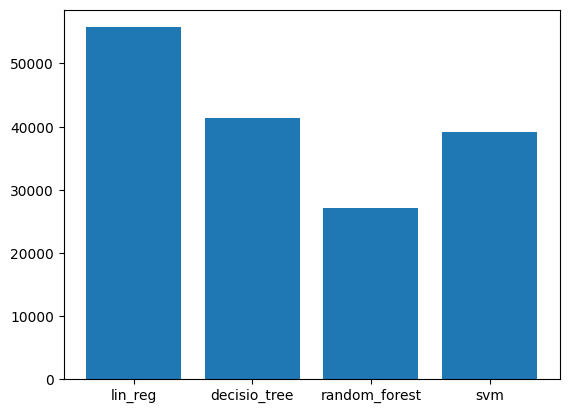

In [15]:
# Bar plot with model performances
scores_1 = [lin_reg_s, tree_reg_s, rand_forest_s, svm_reg_s]
plt.bar(["lin_reg", "decisio_tree", "random_forest", "svm"], scores_1)

Text(0, 0.5, 'Predicted SalePrice')

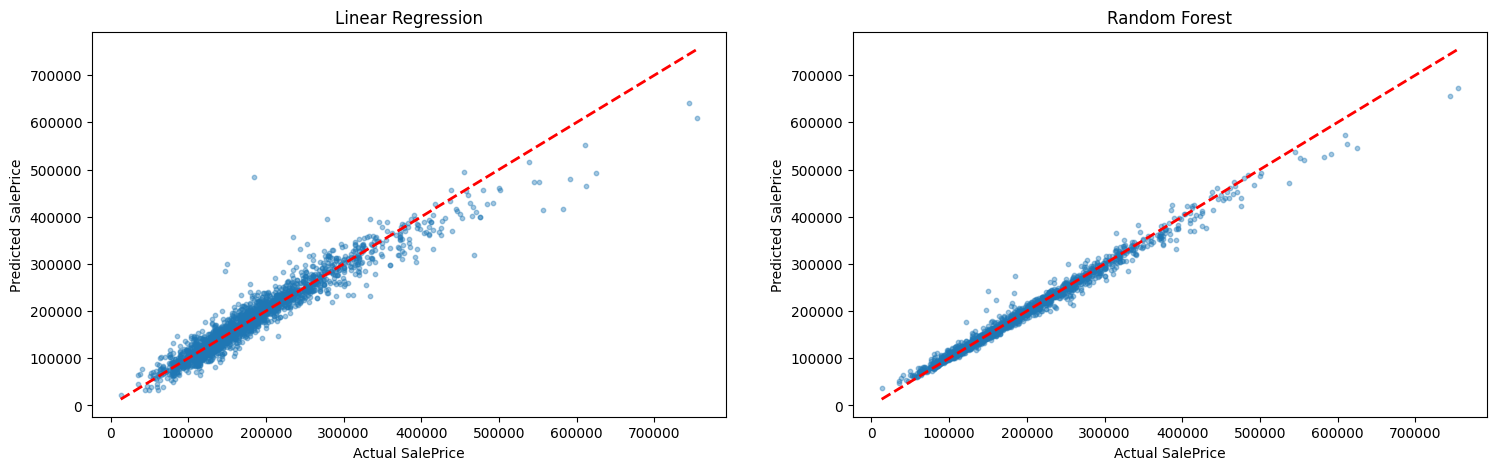

In [16]:
# Fitting linear model and plotting actual and predicted prices 

#Training linear regression model
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_train)

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.title("Linear Regression")
plt.scatter(x=y_train, y=y_pred, alpha=0.4, s=10)
plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 
         'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")

# Training random forest model
rand_forest_reg.fit(X_train,y_train)
y_pred = rand_forest_reg.predict(X_train)

plt.subplot(1,2,2)
plt.title("Random Forest")
plt.scatter(x=y_train, y=y_pred, alpha=0.4, s=10)
plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 
         'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")

>### Observation:
> - random forest predictions sit tighter to the target line

#### Feature engineering

In [17]:
# Custom transformer to combine features with high correlation for better model performance
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df["Total_Living_Area"] =  df["Gr_Liv_Area"] + df["Total_Bsmt_SF"]
        df["Finished_Basement_Ratio"] = np.where(
            df["Total_Bsmt_SF"]>0,
            (df["Total_Bsmt_SF"] - df["Bsmt_Unf_SF"]) / df["Total_Bsmt_SF"],
            0
        )
        df["Basement_Ratio"] = np.where(
            df["Total_Living_Area"]>0,
            df["Total_Bsmt_SF"] / df["Total_Living_Area"],
            0
        )
        return df

In [18]:
# Pipeline for numerical features
num_pipeline = Pipeline([
    ("lot_frontage_transform", LotFrontageTransform(group_col="Neighborhood")),
    ("drop_neighborhood", FunctionTransformer(lambda X: X.drop(columns=["Neighborhood"]), validate=False)),
    ("combine_attr", CombinedAttributesAdder()),
    ("std", StandardScaler()) # Standardizing numerical data
])
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, list(train_set_X.select_dtypes(include=["int64","float64"]))+["Neighborhood"]),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns),
    ('onehot', OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore',dtype=np.int32), nominal_columns),
],remainder="passthrough")

X_train = full_pipeline.fit_transform(train_set_X)
X_train

array([[-0.43195315, -0.35903303, -1.38221511, ...,  1.        ,
         0.        ,  0.        ],
       [-0.43195315, -0.23364856, -0.28512309, ...,  0.        ,
         1.        ,  0.        ],
       [-0.84544275, -0.48799992, -1.71466724, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.43195315, -0.2123929 ,  0.74547851, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.39502604, -0.11280181,  1.21091149, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.71662906,  0.40521519, -0.21863266, ...,  0.        ,
         1.        ,  0.        ]], shape=(2344, 255))

In [19]:
scores_2 = []
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42) # limiting the depth of decision tree to prevent overfitting
rand_forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
svm_reg = SVR(kernel="linear", C=100) # C=1.0 by default which is high regularization

for model in [lin_reg, tree_reg, rand_forest_reg, svm_reg]:
    print("==================================================")
    %time scores_2.append(model_evaluation(model))

Model:  LinearRegression
Scores: [ 44595.25819964  32153.74263974  59012.6621156  108308.64852516
  37226.65752755]
Mean: 56259.39380153798
Standard deviation: 27553.8923966926
CPU times: user 1.14 s, sys: 54 ms, total: 1.2 s
Wall time: 324 ms
Model:  DecisionTreeRegressor
Scores: [35850.06788969 31002.85900191 42892.72673669 37169.36718498
 45108.36592033]
Mean: 38404.677346717624
Standard deviation: 5058.081915153209
CPU times: user 712 ms, sys: 7.93 ms, total: 720 ms
Wall time: 465 ms
Model:  RandomForestRegressor
Scores: [24370.52613406 23756.10498732 28676.14458951 26829.97312686
 26462.0414583 ]
Mean: 26018.958059211574
Standard deviation: 1774.9670662919902
CPU times: user 23.9 s, sys: 0 ns, total: 23.9 s
Wall time: 24.9 s
Model:  SVR
Scores: [27962.07052468 35308.24807931 37450.54343456 29402.922002
 33027.09547359]
Mean: 32630.175902825584
Standard deviation: 3543.2170249925807
CPU times: user 2.42 s, sys: 3.11 ms, total: 2.43 s
Wall time: 2.39 s


>### Observation:
> - overall models performe better after adding new features
> - SVR is much more faster(because of standardscaler)

In [20]:
# Function for plotting bar plots for models comparison
def plot_bar(*scores_list):
    x = np.arange(len(scores_list[0]))
    width = 0.25
    multiplier = 0
    models = ["lin_reg", "decisio_tree", "random_forest", "svm"]
    
    fig, ax = plt.subplots(layout='constrained')
    
    for i, scores in enumerate(scores_list):
        offset = width * i
        rects = ax.bar(x + offset, scores, width, label="model_"+str(i))
    
    ax.set_ylabel('RMSE')
    ax.set_xticks(x + width, models)
    ax.legend(loc='upper left', ncols=4)

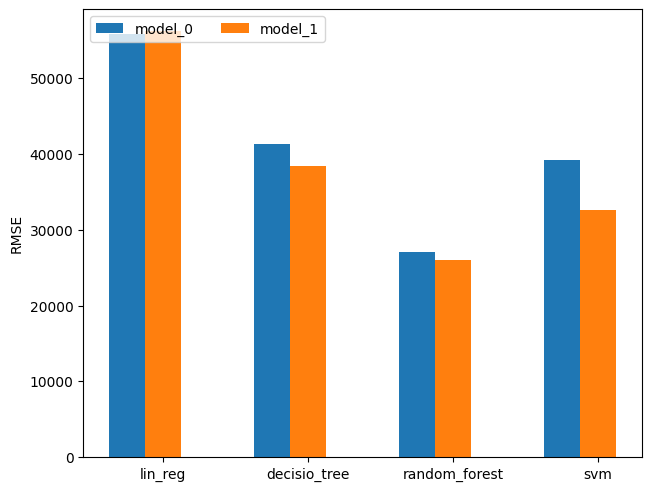

In [21]:
plot_bar(scores_1, scores_2)

#### Lets focus on random forest as it performes better than others

Text(0, 0.5, 'Predicted SalePrice')

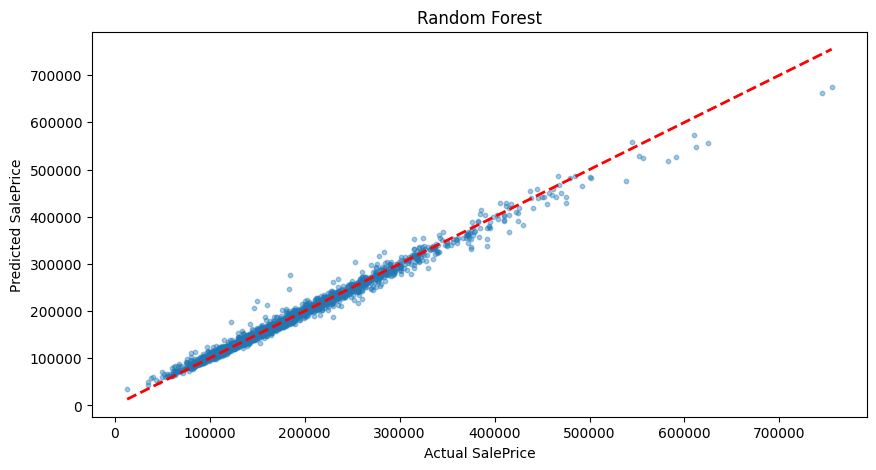

In [23]:
# Training random forest model
rand_forest_reg.fit(X_train,y_train)
y_pred = rand_forest_reg.predict(X_train)
plt.figure(figsize=(10,5))
plt.title("Random Forest")
plt.scatter(x=y_train, y=y_pred, alpha=0.4, s=10)
plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 
         'r--', lw=2)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")